<h2> Nauczanie maszynowe/Ćwiczenia7

<h4> Zadanie1: Zastanów się dlaczego funkcja kosztu MSE może nie być najlepszym pomysłem dla tego problemu? 

Gdy mamy do czynienia z modelem generatywnym, nie będziemy oczekiwać, by model generował dokładnie jedną rzecz, którą podamy jako przykład. W takiej sytuacji nie da się zdefiniować funkcji kosztu MSE.

<h4> Zadanie2: Jaka jest różnica między funkcją ReLU i LeakyReLU. Jakie to ma konsekwencje?

ReLU jest funkcją, która przyjmuje zero dla wszystkich x od minus nieskończoności do zera włącznie oraz dodatnie wartości dla wszystkich x większych od zera (max(0,x)). Taka funkcja ma szereg korzyści, m.in. jest łatwa w implementacji dla komputera. ReLU sprawdza się także w szeregu problemów nauczania maszynowego, co także jest jego zaletą. Definicja funckji ReLU stwarza niestety problem dla wartości negatywnych. Jeśli model osiągnie w pewnym momencie wartość ujemną, to niczego się nie nauczy. Leaky ReLU przyjmuje dla ujemnych x małą część danych x. Taka zmiana powoduje, że z ujmenych obserwacji wynika jakaś informacja dla modelu i zminimalizowany jest problem "dead ReLU", gdy ReLU zawsze ma ujemne x, czyli zawsze jej wynikiem jest 0.



<h4> Zadanie3: Jak zachowuje się funkcja kosztu w kolejnych epokach? Z czego to może wynikać? Czy to ułatwia czy utrudnia dostosowyanie hiperparametrów?

Funkcja kosztu jest niestabilna w kolejnych epokach, raz rośnie, raz maleje. Może to wynikać z faktu, że w modelu używamy stochastycznego spadku gradientu, który z natury będzie powodował jakieś fluktuacje w funkcji kosztu. Może też się tak dziać z uwagi na fakt, że nasz batch jest za duży (?). Takie zachowanie funkcji kosztu utrudnia dostosowywanie hiperparamterów.


<h4> Zadanie4: Generator może realizować swój cel ucząć się bardzo dobrze generować tylko pewien podzbiór danych (np jedną cyfrę). Zjawisko to nosi nazwę $\textbf{mode collapse}$. Poszukaj jak można rozwiązać ten problem.

na podstawie: https://developers.google.com/machine-learning/gan/problems

Rozwiązanie problemu mode collapse opiera się na próbie rozszerzenia zakresu generatora tak, by unieumożliwić mu optymalizację dla pojedynczego dyskryminatora.

"unrolled GANs" - wykorzystują funkcję kosztu generatora, która oparta jest nie tylko na bieżącym dyskryminatorze, ale także jego przyszłych wersjach. Takie rozwiązanie nie może optymalizować tylko dla pojedynczego dyskryminatora, bo funckja kosztu to kontroluje.

"Wasserstein loss" - forsuje generator do spróbowania czegoś nowego, poprzez wspomaganie trenowania dyskriminatora dzięki minimalizowaniu problemu zanikających gradientów.





<h4> Zadanie5: CIFAR10 to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 x 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

https://www.cs.toronto.edu/~kriz/cifar.html

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


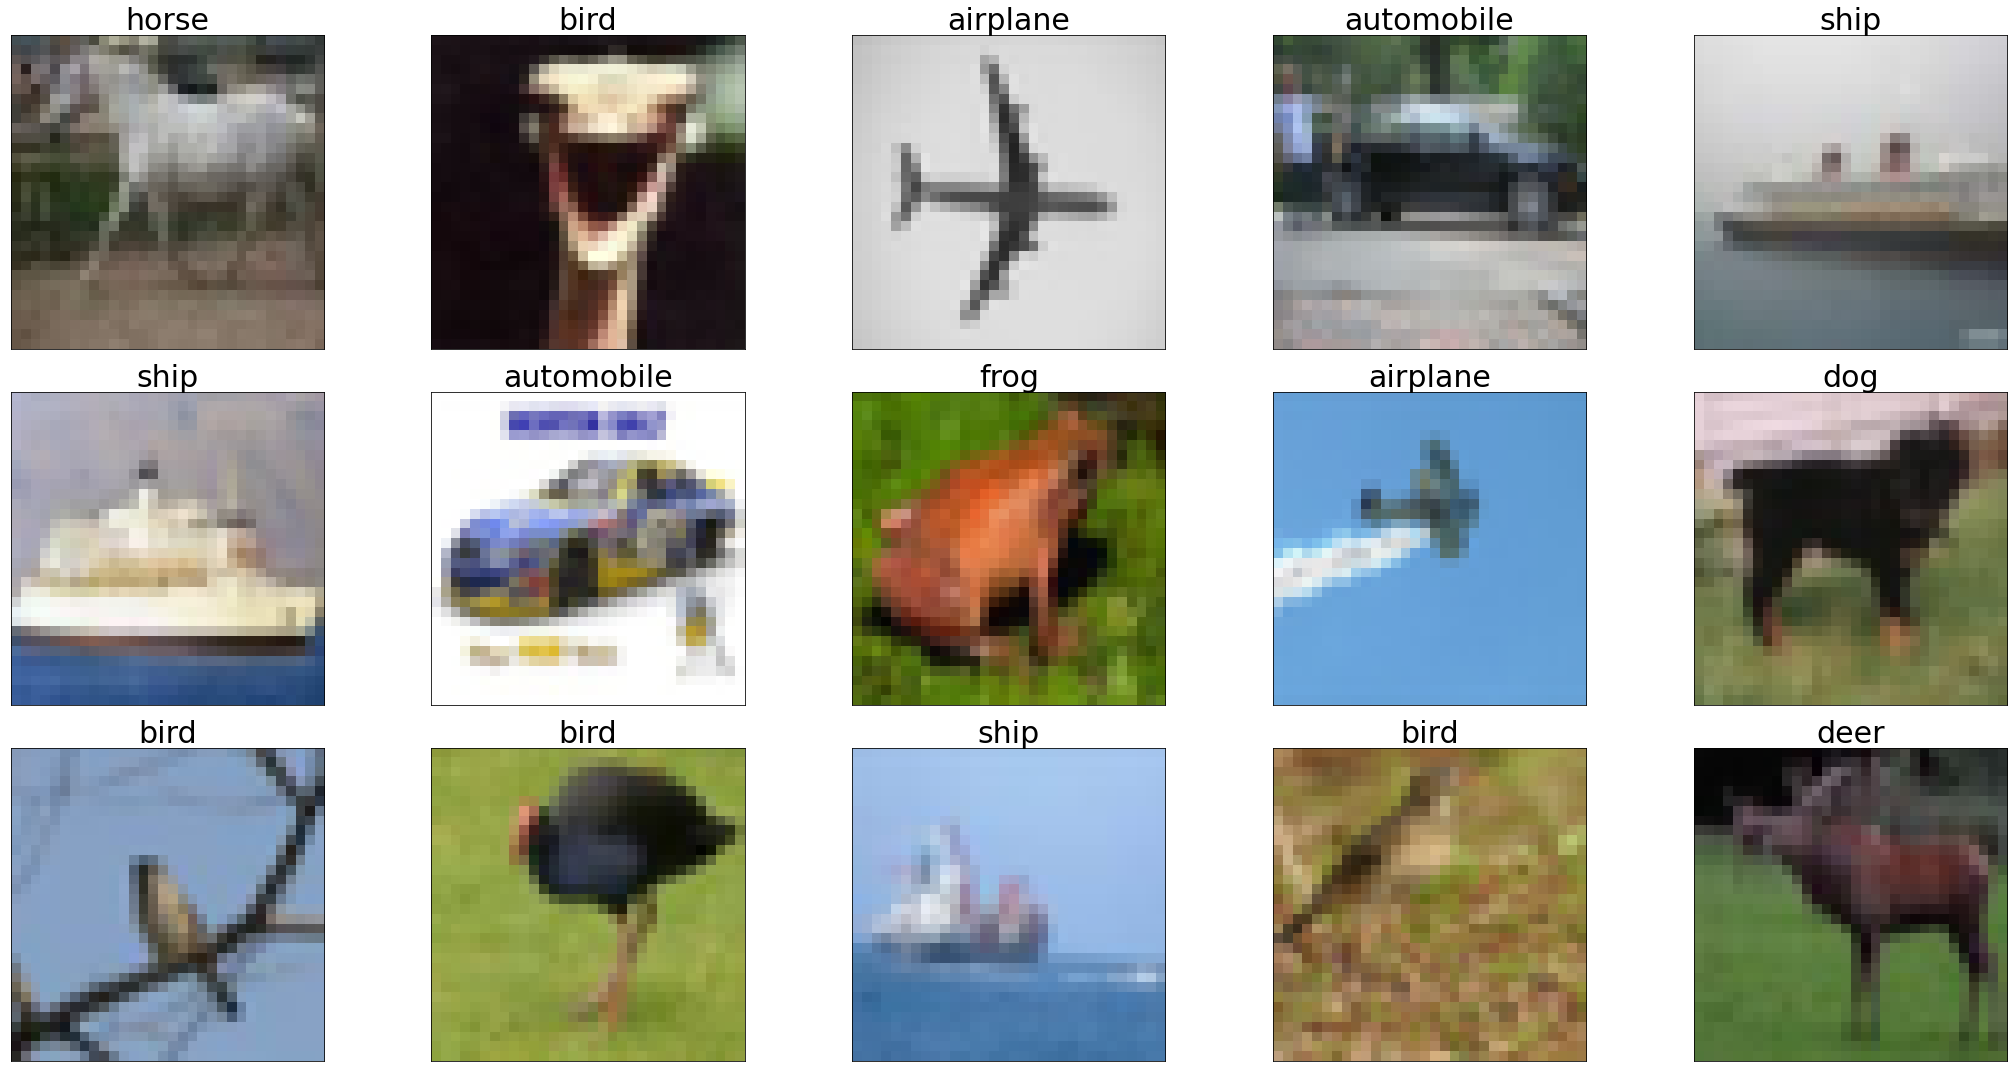

In [4]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

for x, y in loader:
    break

#wizaulizacja
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")


<h4> Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować loss w trakcie trenowania, testowania oraz accuracy na zbiorze testowym (opcjonalnie również na treningowym).

In [5]:
device = torch.device("cpu")

In [6]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import Sequential
from torch.nn import Flatten
from torch.nn import CrossEntropyLoss
from torch.optim import Adam


class CNN (Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.model = Sequential (
        
    # first layer : conv -> relu -> maxpool (on 3 x 32 x 32)
    Conv2d(in_channels = 3, out_channels = 20, kernel_size = 3, padding = 1),
    ReLU(),
    MaxPool2d(kernel_size = 2),
  
    # second layer: conv -> relu -> maxpool
    Conv2d(in_channels = 20, out_channels = 60, kernel_size= 3, padding = 1),
    ReLU(),
    MaxPool2d(kernel_size = 2),
  
    # third layer: conv -> relu -> maxpool
    Conv2d(in_channels = 60, out_channels = 60, kernel_size = 3, padding = 1),
    ReLU(),
    MaxPool2d(kernel_size=2),
  
    # FC layer and final RELU
    Flatten(),
    Linear(in_features = 960, out_features= 400),
    ReLU(),
  
    # Softmax on 10
    Linear(in_features = 400, out_features = 10),
    LogSoftmax(dim=1),
    )

  def forward(self, x):
      return self.model(x)

In [7]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import math

#  dataset prep
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
training_samples = math.floor(len(dataset) * 0.6)
validate_samples = math.floor(len(dataset) * 0.2)
test_samples =     math.floor(len(dataset) * 0.2)
trainset, validset, testset = random_split(dataset, \
[training_samples, validate_samples, test_samples], \
  generator=torch.Generator().manual_seed(101))

# data loaders
tn_loader   = DataLoader(trainset, batch_size = 15, shuffle = True)
vn_loader   = DataLoader(validset, batch_size = 100, shuffle = True)
tt_loader   = DataLoader(testset,  batch_size = 30, shuffle = True)



Files already downloaded and verified


In [8]:
model = CNN().to(device)

In [9]:
epochs = 18
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.015)

In [ ]:
#validation loop
for e in range(10):
  print(f"epoch: {e+1}/10")
  model.train()
  total_loss = 0
  correct = 0

  for batch, (x, y) in enumerate(vn_loader):
      x, y = (x.to(device), y.to(device))
      pred = model(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  print("epoch loss: ", round(float((total_loss/len(vn_loader))),4))

epoch: 1/10
epoch loss:  2.1559
epoch: 2/10
epoch loss:  1.9954
epoch: 3/10
epoch loss:  1.9715
epoch: 4/10
epoch loss:  1.8942
epoch: 5/10
epoch loss:  1.8006
epoch: 6/10
epoch loss:  1.7342
epoch: 7/10
epoch loss:  1.6984
epoch: 8/10
epoch loss:  1.6713
epoch: 9/10
epoch loss:  1.6463
epoch: 10/10
epoch loss:  1.6231


In [10]:
# training loop
for e in range(epochs):
  print(f"epoch: {e+1}/{epochs}")
  model.train()
  total_loss = 0
  correct = 0

  for batch, (x, y) in enumerate(tn_loader):
      x, y = (x.to(device), y.to(device))
      pred = model(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  print("epoch loss: ", round(float((total_loss/len(tn_loader))),4))

epoch: 1/18
epoch loss:  2.0499
epoch: 2/18
epoch loss:  1.8085
epoch: 3/18
epoch loss:  1.6579
epoch: 4/18
epoch loss:  1.586
epoch: 5/18
epoch loss:  1.5417
epoch: 6/18
epoch loss:  1.5105
epoch: 7/18
epoch loss:  1.4764
epoch: 8/18
epoch loss:  1.4474
epoch: 9/18
epoch loss:  1.425
epoch: 10/18
epoch loss:  1.4083
epoch: 11/18
epoch loss:  1.391
epoch: 12/18
epoch loss:  1.3849
epoch: 13/18
epoch loss:  1.3696
epoch: 14/18
epoch loss:  1.3653
epoch: 15/18
epoch loss:  1.3518
epoch: 16/18
epoch loss:  1.3454
epoch: 17/18
epoch loss:  1.3358
epoch: 18/18
epoch loss:  1.3334


In [11]:
# testing
accurate = 0
model.eval()
  
with torch.no_grad():
    for batch, (x, y) in enumerate(tt_loader):
      x, y = (x.to(device), y.to(device))
      pred = model(x)
      _, y_pred = torch.max(pred.data, 1)
      accurate += (y_pred == y).sum().item()
    print(f"Achieved accuracy {100 * accurate / len(testset)}% :-)")

Achieved accuracy 48.64% :-)


Musiałbym skorzystać z jakiejś architektury sieci żeby ulepszyć moje wyniki, puszczałem też na 45 epokach i było 50% accuracy.